# Actividad 5. Resolver un problema con AS

## Estudiantes
Tom Arc,<br>
Alejandro Hermosillo,<br>
Mauricio Flores<br>

## Importación de librerías

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

## Definición de funciones

 Función que retorna las probabilidades de cada arista camino adyacente al punto actual

In [2]:
def get_probabilities_adjs(adj, path):
  # get sum
  sum = 0
  for edge in adj:
    if edge[0] not in path:
      sum += (edge[2] * 1/edge[1])

  # get probabilities
  probabilities = []
  for edge in adj:
    if edge[0] not in path:
      probabilities.append((edge[0], (edge[2] * 1/edge[1]) / sum,  edge[1]))

  return probabilities

Función que escoge una camino de los posibles caminos adyacentes del punto actual

In [3]:
def choose_edge(adj, path):
  probabilities = get_probabilities_adjs(adj, path)
  thresholds = []
  sum = 0

  for probability in probabilities:
    sum += probability[1]
    thresholds.append(sum)

  r = random.random()
  for i in range(len(thresholds)):
    if r < thresholds[i]:
      return (probabilities[i][0], probabilities[i][2])

Función que genera un tour que recorre una hormiga. Esta función retorna nulo si la hormiga no logra realizar un recorrido válido, el cual requiere que visite todos los puntos y no pase dos veces por el mismo lugar. La función retorna el tour encontrado, si es que encontró uno válido y el costo de dicho tour. 

In [4]:
def ant(cities):
  # Define random city to start
  possible_cities = ['A', 'B', 'C', 'D', 'E']
  r = random.randint(0, len(possible_cities) - 1)

  start_city = possible_cities[r]
  name_city = start_city

  # Generate path
  cost = 0
  path = []
  path.append(start_city)

  while len(path) < len(cities):
    random_city = choose_edge(cities[name_city], path)

    if random_city == None:
      return None

    name_city = random_city[0]
    cost_city = random_city[1]
    path.append(name_city)
    cost += cost_city

  for adj in cities[path[-1]]:
    if start_city == adj[0]:
      cost += adj[1]
      return (path, cost)

  return None

Esta función genera un tour válida que recorre una hormiga. Simplemente llama a la función ant() hasta que se genere un path válido

In [5]:
def generate_ant_path(cities):
  path = ant(cities)

  while path == None:
    path = ant(cities)

  return path

Función que actualiza el nivel de feromonas con base en el número de hormigas que pasan por cierto camino, así como de la calidad de dicho camino. 

In [6]:
def update_pheromone(cities, solutions):
  for path in solutions:
    for i in range(len(path)):
      if i == len(path)-1:
        city = path[0]
      else:
        city = path[i+1]

      for j in range(len(cities[path[i]])):
        if cities[path[i]][j][0] == city:
          cities[path[i]][j][2] += 1/cities[path[i]][j][1]

Función que simula la evaporación de la feromona. Conforme pasa el tiempo, los niveles de feromona se evaporan y dejan de influenciar en la decisión del camino. 

In [7]:
def decay_pheromone(cities, vaporization_constant = 0):
  factor = 1 - vaporization_constant

  for city in cities:
    for i in range(len(cities[city])):
      cities[city][i][2] *= factor

Función que simula n hormigas recorriendo los diferentes caminos. La función retorna la mejor solución encontrada, la cual será la de menor costo.

In [8]:
def simulation(cities, n_iterations, n_ants, evaporation_constant):
  initial_path = generate_ant_path(cities)

  best = {'path': initial_path[0], 'cost': initial_path[1]}
  number_ant = 0
  for i in range(n_iterations):
    solutions = []
    for ant in range(n_ants):
      path = generate_ant_path(cities)
      candidate = {'path': path[0], 'cost': path[1]}
      if candidate['cost'] < best['cost']:
        best = candidate
      solutions.append(candidate['path'])
      number_ant += 1
      print(f'Camino de la hormiga {number_ant}: {candidate}')

    decay_pheromone(cities, evaporation_constant)
    update_pheromone(cities, solutions)

  return best

Función que gráfica 

In [9]:
def plot_graph(points, cities):
  plt.xlim((-1, 5))
  plt.ylim((-1, 3))
  sns.scatterplot(data = points, x = 'x', y = 'y')

  # Get connections to print graph
  for city in cities:
    # Coord of the current city
    current_city = points[points['Label'] == city].iloc[0]
    for adj in cities[city]:
      adj_city = points[points['Label'] == adj[0]].iloc[0]
      sns.lineplot(x = [current_city['x'], adj_city['x']], y = [current_city['y'], adj_city['y']], color = 'blue', linewidth=1.5)

  for index, point in points.iterrows():
    plt.text(point['x'] + 0.1, point['y'], point['Label'], horizontalalignment='left', size='medium', color='red')

In [10]:
def plot_solution(points, cities, solution):
  plt.xlim((-1, 5))
  plt.ylim((-1, 3))
  # Print solution
  previous_city = solution[0]
  previous_coord = points[points['Label'] == previous_city].iloc[0]
  for city in solution[1:]:
    current_coord = points[points['Label'] == city].iloc[0]
    sns.lineplot(x = [previous_coord['x'], current_coord['x']], y = [previous_coord['y'], current_coord['y']], color = 'green', linewidth = 2)
    previous_city = city
    previous_coord = points[points['Label'] == previous_city].iloc[0]

  initial_city = solution[0]
  initial_coord = points[points['Label'] == initial_city].iloc[0]
  sns.lineplot(x = [previous_coord['x'], initial_coord['x']], y = [previous_coord['y'], initial_coord['y']], color = 'green', linewidth = 2)

## Creación del grafo y ejecución de la simulación

### Creación del grafo

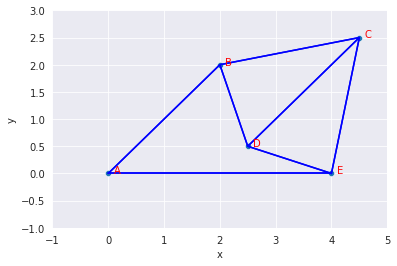

In [11]:
points = pd.DataFrame({'x': [0, 2, 4, 4.5, 2.5], 'y': [0, 2, 0, 2.5, 0.5], 'Label': ['A', 'B', 'E', 'C', 'D']})

cities = {
    'A': [['B', 3, 8], ['E', 21, 8]],
    'B': [['A', 3, 8], ['C', 5, 8], ['D', 6, 8]],
    'C': [['B', 5, 8], ['D', 5, 8], ['E', 7, 8]],
    'D': [['B', 6, 8], ['C', 5, 8], ['E', 4, 8]],
    'E': [['A', 21, 8], ['D', 4, 8], ['C', 7, 8]]
} 

plot_graph(points, cities)
plt.show()

**a)** Ejecute dos ciclos completos de búsqueda de un sistema de hormigas que intente resolver  el  problema  del  vendedor  viajero  para  el  grafo  ponderado  de  abajo.  Los números representan las distancias entre las ciudades que se conectan mediante un camino.  Cada  ciclo  termina  cuando  cada  hormiga  regresa  a  su  ciudad  inicial  y  se calcula el nuevo nivel de feromonas de cada arco del grafo. 

Camino de la hormiga 1: {'path': ['D', 'C', 'E', 'A', 'B'], 'cost': 42}
Camino de la hormiga 2: {'path': ['A', 'E', 'D', 'C', 'B'], 'cost': 38}
Camino de la hormiga 3: {'path': ['A', 'B', 'D', 'C', 'E'], 'cost': 42}
Camino de la hormiga 4: {'path': ['E', 'D', 'C', 'B', 'A'], 'cost': 38}
Camino de la hormiga 5: {'path': ['D', 'C', 'E', 'A', 'B'], 'cost': 42}
Camino de la hormiga 6: {'path': ['B', 'A', 'E', 'D', 'C'], 'cost': 38}
['B', 'C', 'D', 'E', 'A']


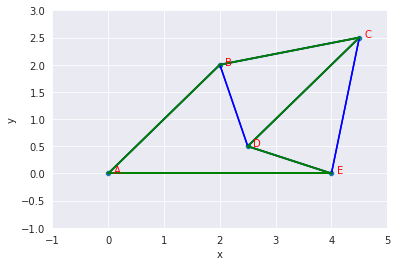

In [12]:
best_solution = simulation(cities, 2, 3, 0.6)
print(best_solution['path'])

plot_graph(points, cities)
plot_solution(points, cities, best_solution['path'])
plt.show()

**b)** Simule  un  AS  con  m  =  3  hormigas  (no  necesariamente  todas  las  hormigas  deben comenzar  en una  ciudad  diferente)  y  muestre  el  valor  seleccionado para  cada parámetro del método. 

Camino de la hormiga 1: {'path': ['A', 'B', 'C', 'D', 'E'], 'cost': 38}
Camino de la hormiga 2: {'path': ['B', 'C', 'D', 'E', 'A'], 'cost': 38}
Camino de la hormiga 3: {'path': ['E', 'D', 'C', 'B', 'A'], 'cost': 38}
Camino de la hormiga 4: {'path': ['A', 'B', 'C', 'D', 'E'], 'cost': 38}
Camino de la hormiga 5: {'path': ['D', 'C', 'B', 'A', 'E'], 'cost': 38}
Camino de la hormiga 6: {'path': ['D', 'B', 'A', 'E', 'C'], 'cost': 42}
Camino de la hormiga 7: {'path': ['E', 'D', 'C', 'B', 'A'], 'cost': 38}
Camino de la hormiga 8: {'path': ['E', 'D', 'C', 'B', 'A'], 'cost': 38}
Camino de la hormiga 9: {'path': ['A', 'B', 'D', 'C', 'E'], 'cost': 42}
Camino de la hormiga 10: {'path': ['E', 'D', 'C', 'B', 'A'], 'cost': 38}
Camino de la hormiga 11: {'path': ['C', 'B', 'A', 'E', 'D'], 'cost': 38}
Camino de la hormiga 12: {'path': ['D', 'C', 'B', 'A', 'E'], 'cost': 38}
Camino de la hormiga 13: {'path': ['A', 'B', 'C', 'D', 'E'], 'cost': 38}
Camino de la hormiga 14: {'path': ['A', 'B', 'D', 'C', 'E'],

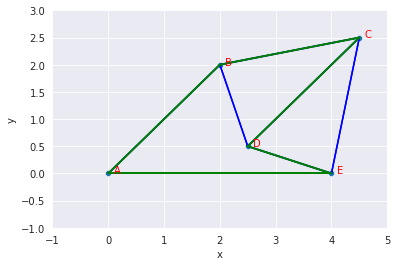

In [13]:
best_solution = simulation(cities, 10, 3, 0.6)
print(best_solution['path'])

plot_graph(points, cities)
plot_solution(points, cities, best_solution['path'])
plt.show()

Como se observa, el mejor camino es aquel que tiene un costo de 38, es decir, una distancia de 38 y su camino es 'C' -> 'D' -> 'E' -> 'A' -> 'B' -> 'C'. Algo interesante e importante a notar es que conforme hayan pasado más hormigas, los resultados óptimos tienden a estabilizarse, lo que indica que cada vez menos hormigas pasaran por caminos con peores costos y entre más pasen las hormigas por los caminos óptimos, menos exploración de las rutas probablemente poco óptimas habrá y más explotación habrá de las vías ya probadas óptimas. 